# Transfer Learning with TensorFlow: Scaling up

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101.

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

In [ ]:
# Downloading the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-06 03:14:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-06 03:14:29 (54.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Importing from helper functions
from helper_functions import *

In [ ]:
# Getting the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-02-06 03:14:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   136MB/s    in 10s     

2023-02-06 03:14:44 (152 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Unzipping the data
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_1

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                        image_size=IMG_SIZE,
                                                                        label_mode="categorical")
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical",
                                                        shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
num_classes = len(train_data_all_10_percent.class_names)

## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB2 backboned-model (w'll create our own top layers)
* Compile our model
* Fit the model

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [ ]:
# Downloading the EfficientNetB0 backbone model
conv_base = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,))
conv_base.trainable = False

# Build the model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = conv_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[checkpoint_callback,
                                   create_tensorboard_callback(dir_name="tensorboard_callback",
                                                               experiment_name="transfer_learning_on_10%_of_101_food classes")])

Saving TensorBoard log files to: tensorboard_callback/transfer_learning_on_10%_of_101_food classes/20230205-122249
Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3184 - accuracy: 0.2832

237/237 [==============================] - 75s 291ms/step - loss: 3.3184 - accuracy: 0.2832 - val_loss: 2.4734 - val_accuracy: 0.4327
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.0941 - accuracy: 0.5236

237/237 [==============================] - 68s 285ms/step - loss: 2.0941 - accuracy: 0.5236 - val_loss: 2.0145 - val_accuracy: 0.5072
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.7087 - accuracy: 0.5988

237/237 [==============================] - 69s 291ms/step - loss: 1.7087 - accuracy: 0.5988 - val_loss: 1.8293 - val_accuracy: 0.5318
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.4867 - accuracy: 0.6440

237/237 [==============================] - 69s 291ms/step - loss: 1.4867 - accuracy: 0.6440 - val_loss: 1.7495 - val_accuracy: 0.5429
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.3175 - accuracy: 0.6845

237/237 [==============================] - 70s 294ms/step - loss: 1.3175 - accuracy: 0.6845 - val_loss: 1.7235 - val_accuracy: 0.5450


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.5248 - accuracy: 0.5943


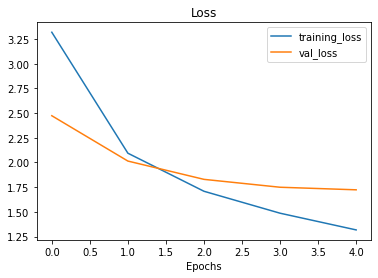

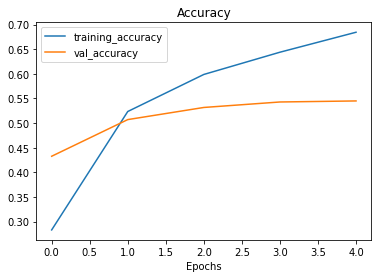

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
conv_base.trainable = True

# Refreeze every layer except the last 5
for layer in conv_base.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate while fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 44s 147ms/step - loss: 1.0937 - accuracy: 0.7228 - val_loss: 1.6592 - val_accuracy: 0.5535
Epoch 6/10
237/237 [==============================] - 32s 134ms/step - loss: 0.9483 - accuracy: 0.7497 - val_loss: 1.6577 - val_accuracy: 0.5567
Epoch 7/10
237/237 [==============================] - 33s 140ms/step - loss: 0.8818 - accuracy: 0.7673 - val_loss: 1.6799 - val_accuracy: 0.5553
Epoch 8/10
237/237 [==============================] - 34s 141ms/step - loss: 0.8256 - accuracy: 0.7811 - val_loss: 1.6653 - val_accuracy: 0.5593
Epoch 9/10
237/237 [==============================] - 33s 137ms/step - loss: 0.7534 - accuracy: 0.8045 - val_loss: 1.6879 - val_accuracy: 0.5593
Epoch 10/10
237/237 [==============================] - 34s 140ms/step - loss: 0.6989 - accuracy: 0.8144 - val_loss: 1.6978 - val_accuracy: 0.5588


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 60s 76ms/step - loss: 1.4378 - accuracy: 0.6223


[1.4378480911254883, 0.62225741147995]

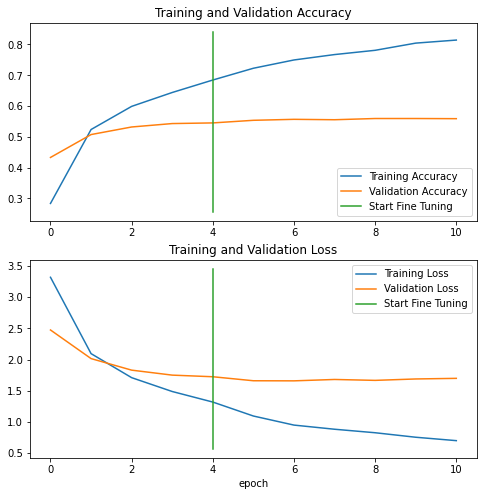

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Machine Learning/Tensorflow Dev Certificate/101_food_classes_10_percent_big_dog_model")

In [ ]:
unzip_data("/content/101_food_classes_10_percent_big_dog_model-20230205T170926Z-001.zip")

In [ ]:
# Load and evaluate saved model
loaded_model = keras.models.load_model("/content/101_food_classes_10_percent_big_dog_model")

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 68s 74ms/step - loss: 1.4378 - accuracy: 0.6223


[1.4378482103347778, 0.62225741147995]

In [ ]:
pred_probs = loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 62s 77ms/step


In [ ]:
len(pred_probs)

25250

In [ ]:
import numpy as np
np.argmax(pred_probs[1])

0

In [ ]:
# Let's see what the first 10 predictions look like
for i in pred_probs[:10]:
  print(test_data.class_names[np.argmax(i)])

apple_pie
apple_pie
apple_pie
fish_and_chips
bread_pudding
poutine
cup_cakes
garlic_bread
apple_pie
apple_pie


In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 46,  0,  0])

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions
One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy scores.

In [ ]:
# Let's try sklearn's accuracy score function and see eaht it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6222574257425743

In [ ]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

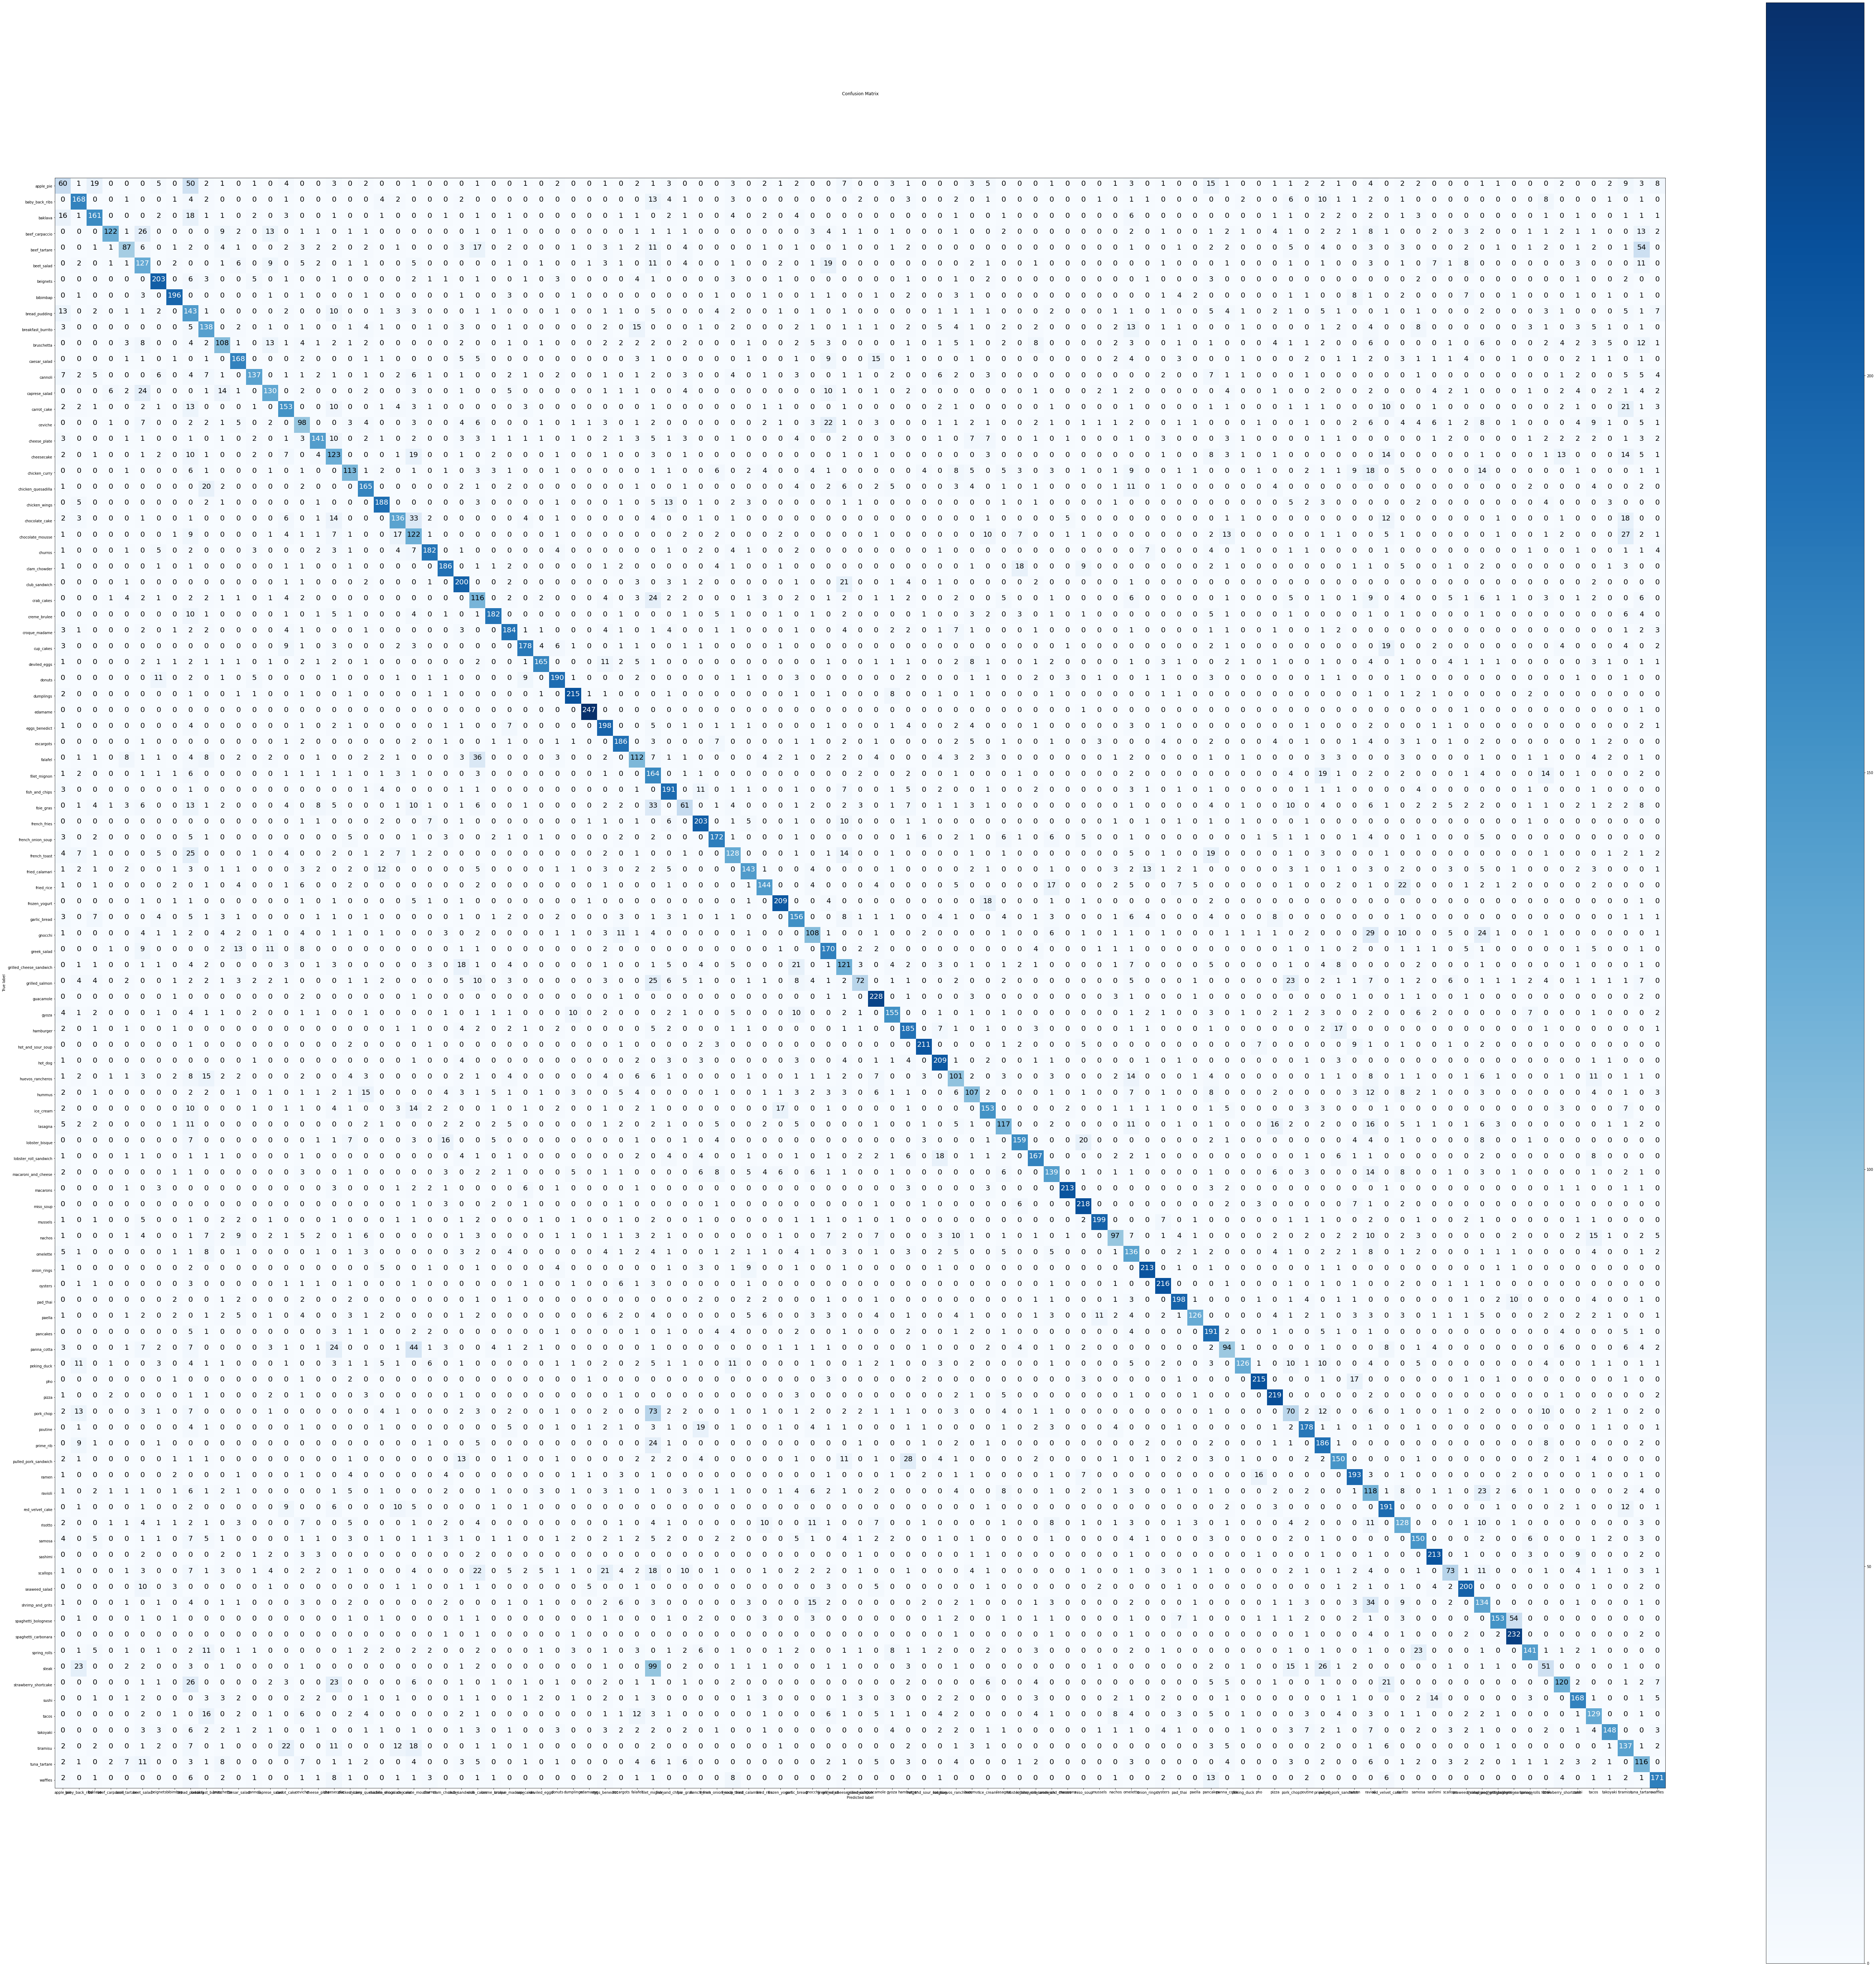

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.24      0.27       250
           1       0.62      0.67      0.64       250
           2       0.68      0.64      0.66       250
           3       0.86      0.49      0.62       250
           4       0.61      0.35      0.44       250
           5       0.41      0.51      0.46       250
           6       0.74      0.81      0.77       250
           7       0.84      0.78      0.81       250
           8       0.27      0.57      0.36       250
           9       0.48      0.55      0.51       250
          10       0.55      0.43      0.48       250
          11       0.67      0.67      0.67       250
          12       0.80      0.55      0.65       250
          13       0.62      0.52      0.56       250
          14       0.59      0.61      0.60       250
          15       0.44      0.39      0.42       250
          16       0.73      0.56      0.64       250
          17       0.40    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3125,
  'recall': 0.24,
  'f1-score': 0.27149321266968324,
  'support': 250},
 '1': {'precision': 0.6153846153846154,
  'recall': 0.672,
  'f1-score': 0.6424474187380497,
  'support': 250},
 '2': {'precision': 0.679324894514768,
  'recall': 0.644,
  'f1-score': 0.6611909650924025,
  'support': 250},
 '3': {'precision': 0.8591549295774648,
  'recall': 0.488,
  'f1-score': 0.6224489795918366,
  'support': 250},
 '4': {'precision': 0.6126760563380281,
  'recall': 0.348,
  'f1-score': 0.44387755102040816,
  'support': 250},
 '5': {'precision': 0.41233766233766234,
  'recall': 0.508,
  'f1-score': 0.4551971326164875,
  'support': 250},
 '6': {'precision': 0.7408759124087592,
  'recall': 0.812,
  'f1-score': 0.7748091603053436,
  'support': 250},
 '7': {'precision': 0.8412017167381974,
  'recall': 0.784,
  'f1-score': 0.8115942028985508,
  'support': 250},
 '8': {'precision': 0.26579925650557623,
  'recall': 0.572,
  'f1-score': 0.36294416243654826,
  'support': 250},
 

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop thorugh classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.27149321266968324,
 'baby_back_ribs': 0.6424474187380497,
 'baklava': 0.6611909650924025,
 'beef_carpaccio': 0.6224489795918366,
 'beef_tartare': 0.44387755102040816,
 'beet_salad': 0.4551971326164875,
 'beignets': 0.7748091603053436,
 'bibimbap': 0.8115942028985508,
 'bread_pudding': 0.36294416243654826,
 'breakfast_burrito': 0.5139664804469274,
 'bruschetta': 0.48214285714285715,
 'caesar_salad': 0.6733466933867734,
 'cannoli': 0.6492890995260663,
 'caprese_salad': 0.5639913232104122,
 'carrot_cake': 0.6,
 'ceviche': 0.416135881104034,
 'cheese_plate': 0.636568848758465,
 'cheesecake': 0.4432432432432432,
 'chicken_curry': 0.510158013544018,
 'chicken_quesadilla': 0.6666666666666666,
 'chicken_wings': 0.752,
 'chocolate_cake': 0.5799573560767591,
 'chocolate_mousse': 0.4053156146179402,
 'churros': 0.7615062761506276,
 'clam_chowder': 0.7454909819639279,
 'club_sandwich': 0.7029876977152901,
 'crab_cakes': 0.4187725631768953,
 'creme_brulee': 0.7711864406779662,
 'cro

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_names,f1-score
33,edamame,0.968627
63,macarons,0.893082
75,pho,0.861723
54,hot_and_sour_soup,0.854251
32,dumplings,0.849802


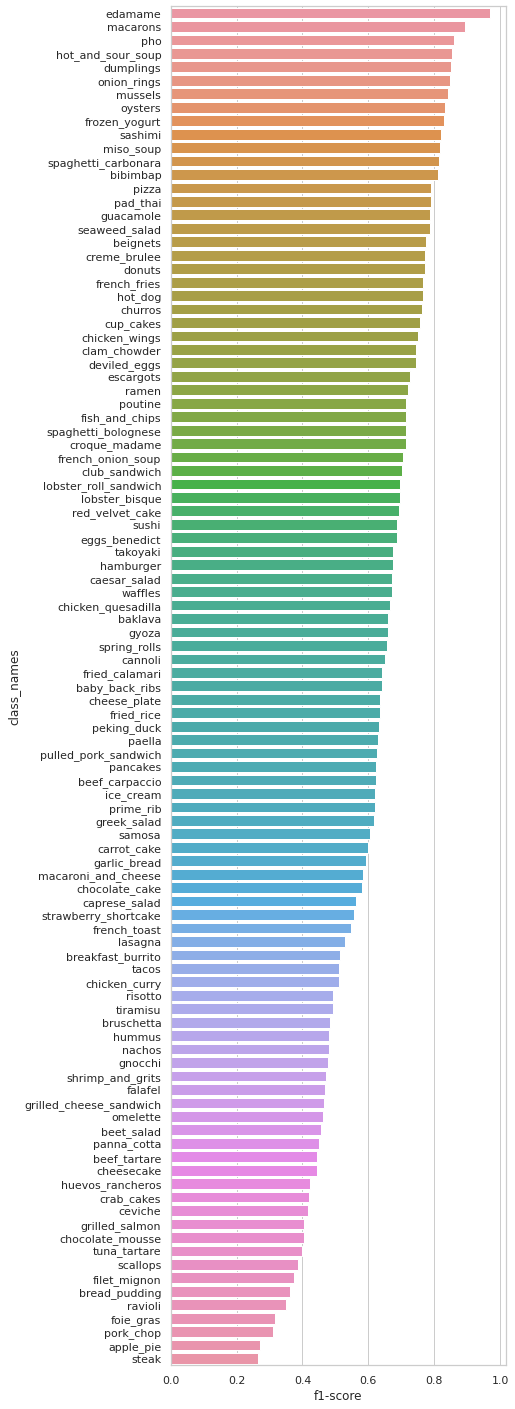

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initilize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 25))

sns.barplot(x=f1_scores["f1-score"], y=f1_scores["class_names"]);

To visualize our model's predictions on our own images, we'll need a function to load and preprocess the input images.

* Read in a target images filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the imahe to get all of the pixel values between 0 and 1 (if necessary)

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filenames, turns it into a tensor
  and reshapes into a speficied shape (img_shape, img_shape, 3).

  Args:
    filename (str): path to target images
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode the image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=(img_shape, img_shape))

  # Scale? yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 24ms/step


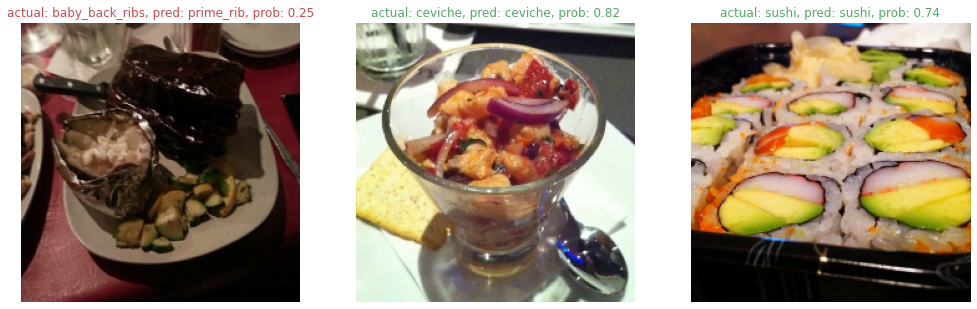

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  
  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
# Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10] 

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# Create a DataFrame of different parameters for each of out test images
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.200907,apple_pie,apple_pie
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.846938,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.640376,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,38,0.299281,apple_pie,fish_and_chips
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.698416,apple_pie,bread_pudding
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.986903,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.907993,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.552932,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.357869,waffles,strawberry_shortcake


In [ ]:
# Find our in out DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.200907,apple_pie,apple_pie,True
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.846938,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.640376,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,38,0.299281,apple_pie,fish_and_chips,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.698416,apple_pie,bread_pudding,False
...,...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.986903,waffles,waffles,True
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.907993,waffles,cheese_plate,False
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.552932,waffles,waffles,True
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.357869,waffles,strawberry_shortcake,False


In [ ]:
# Sort the DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong[:10]

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999413,sushi,sashimi,False
11642,b'/content/101_food_classes_10_percent/test/ga...,46,10,0.998947,garlic_bread,bruschetta,False
5114,b'/content/101_food_classes_10_percent/test/ch...,20,38,0.998232,chicken_wings,fish_and_chips,False
18001,b'/content/101_food_classes_10_percent/test/pa...,72,67,0.998177,pancakes,omelette,False
14482,b'/content/101_food_classes_10_percent/test/hu...,57,51,0.997752,hummus,guacamole,False
191,b'/content/101_food_classes_10_percent/test/ap...,0,31,0.997706,apple_pie,donuts,False
16271,b'/content/101_food_classes_10_percent/test/mu...,65,69,0.997509,mussels,oysters,False
10880,b'/content/101_food_classes_10_percent/test/fr...,43,68,0.997156,fried_calamari,onion_rings,False
10847,b'/content/101_food_classes_10_percent/test/fr...,43,68,0.996873,fried_calamari,onion_rings,False
9326,b'/content/101_food_classes_10_percent/test/fi...,37,79,0.996503,filet_mignon,prime_rib,False


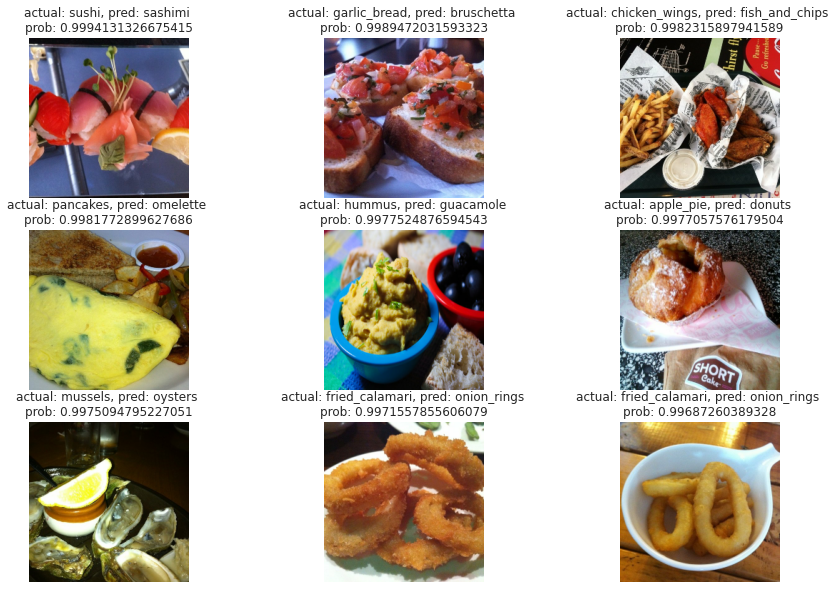

In [ ]:
# Visualize
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)


## Test out the big dog model on our own custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2023-02-06 06:56:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.142.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  46.0MB/s    in 0.3s    

2023-02-06 06:56:24 (46.0 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
# Get the custom food images filespaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg']

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);